In [48]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from histogrammi_3D import *
from klusterointi import *
# tai from ... import *

In [45]:
df = database_query("SELECT * FROM hyvatReititDB limit 1000000")
df.head()

,ajokerta,node_id,timestamp,x,y,grid_id,kesto,dayofweek,current_hour
0,1,1,2020-06-24 15:20:12,22,11,352,64858.412,2,8
1,1,1,2020-06-24 15:20:13,22,11,352,64858.412,2,8
2,1,1,2020-06-24 15:20:14,22,11,352,64858.412,2,8
3,1,1,2020-06-24 15:20:21,26,12,386,64858.412,2,8
4,1,1,2020-06-24 15:20:22,25,12,385,64858.412,2,8


In [46]:
import numpy as np
import matplotlib.pyplot as plt


In [49]:
df = df_to_features(df)

In [50]:
df

,ajokerta,node_id,kesto,dayofweek,current_hour,0,1,2,3,4,...,15,16,17,18,19,20,21,22,23,24
0,1,1,64858.412,2,8,401,818,411,505,535,...,592,441,471,576,337,562,682,550,367,385
1,2,1,755.000,3,8,681,472,711,440,680,...,651,469,445,741,799,591,529,548,769,580
2,3,1,1434.018,3,9,490,413,373,521,491,...,550,352,372,626,460,371,608,565,374,551
3,4,1,769.999,3,10,415,656,505,652,805,...,824,715,576,666,636,606,693,355,817,384
4,5,1,285.000,3,12,605,715,745,441,471,...,343,635,625,847,595,552,801,344,411,793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,2236,9,420.002,6,4,505,385,475,652,354,...,345,795,414,829,711,725,830,755,578,535
2194,2237,9,346.999,6,6,682,650,620,832,833,...,351,500,831,798,405,737,587,767,829,828
2195,2238,9,1259.000,6,7,547,370,381,546,368,...,595,683,655,367,741,441,373,372,564,563
2196,2239,9,2826.000,6,8,290,712,772,684,644,...,565,531,534,741,501,608,626,579,580,581


In [67]:
x = df.iloc[:, 5:]

In [66]:
X

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,401,818,411,505,535,534,565,373,352,381,...,592,441,471,576,337,562,682,550,367,385
1,681,472,711,440,680,589,355,710,473,669,...,651,469,445,741,799,591,529,548,769,580
2,490,413,373,521,491,520,401,370,461,412,...,550,352,372,626,460,371,608,565,374,551
3,415,656,505,652,805,416,716,655,686,353,...,824,715,576,666,636,606,693,355,817,384
4,605,715,745,441,471,578,655,565,799,816,...,343,635,625,847,595,552,801,344,411,793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,505,385,475,652,354,382,413,580,741,765,...,345,795,414,829,711,725,830,755,578,535
2194,682,650,620,832,833,711,406,647,681,677,...,351,500,831,798,405,737,587,767,829,828
2195,547,370,381,546,368,466,290,516,625,369,...,595,683,655,367,741,441,373,372,564,563
2196,290,712,772,684,644,471,713,649,742,564,...,565,531,534,741,501,608,626,579,580,581


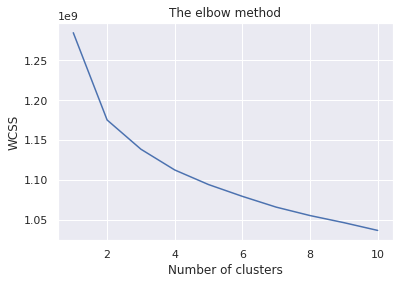

In [68]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [70]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)

In [71]:
#Visualising the clusters
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')

plt.legend()


TypeError: '(array([False,  True, False, ..., False, False,  True]), 0)' is an invalid key